# **Model Comparison**

---

Let's define our Baseline:

We will make a median-based baseline among AI-ML job titles and top20 countries (in frequency terms)

In [227]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
# The MedianBaselineModel class is defined here. This class represents a baseline model 
# that uses median values for predictions and follows the scikit-learn estimator interface.
class MedianBaselineModel(BaseEstimator, RegressorMixin):
    
    def fit(self, X, y):
        # Concatenating features and target variable and then calculating the median
        self.baseline_model = pd.concat([X, y], axis=1)
        self.baseline_model = self.baseline_model.groupby(baseline_features).median().reset_index()
        return self
    
    def predict(self, X):
        # Merging test data with the baseline model to get predictions
        predictions = X.merge(self.baseline_model, on=baseline_features, how='left')
        return predictions['Annual_salary'].fillna(predictions['Annual_salary'].median())

- Data Preprocessing

In [229]:
# Reading the training and testing datasets
train_set = pd.read_csv('../../output/clean_train_df.csv')
test_set = pd.read_csv('../../output/clean_test_df.csv')

# Defining the features to be used in the baseline model
top20countries = ['Country_USA', 'Country_Germany', 'Country_UK & Northern Ireland', 'Country_Canada', 'Country_France', 'Country_India',
       'Country_Spain', 'Country_Brazil', 'Country_Poland', 'Country_Australia', 'Country_Netherlands', 'Country_Italy',
       'Country_Switzerland', 'Country_Israel', 'Country_Sweden', 'Country_Austria', 'Country_Russian Federation',
       'Country_Mexico', 'Country_Denmark', 'Country_Belgium']

AI_ML_devs = ['Data scientist or machine learning specialist',
 'Engineer, data',
 'Data or business analyst',
 'Scientist']

baseline_features = AI_ML_devs + top20countries

# Preparing the feature matrices and target vectors for training and testing sets
X_train = train_set[baseline_features]
y_train = train_set['Annual_salary']

X_test = test_set[baseline_features]
y_test = test_set['Annual_salary']

# Scaling the features using StandardScaler to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting the scaled numpy arrays back to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

- Metrics, fit, and evaluation:

In [230]:
# Defining a function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Creating a scorer function for RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Initializing and fitting the MedianBaselineModel
model = MedianBaselineModel()
model.fit(X_train_scaled, y_train)

# Performing K-Fold Cross-Validation to evaluate the model's performance
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Calculating RMSE using cross-validation
cv_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=kf, scoring=rmse_scorer)

# Displaying the RMSE results from cross-validation
print(f"RMSE scores: {-cv_scores}")
print(f"Mean RMSE: {np.mean(-cv_scores)}")

# Creating a scorer function for R2
r2_scorer = make_scorer(r2_score)
print()
# Calculating R2 scores using cross-validation
r2_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=kf, scoring=r2_scorer)

# Displaying the R2 results from cross-validation
print(f"R2 scores: {r2_scores}")
print(f"Mean R2: {np.mean(r2_scores)}")


mean_rmse_baseline = np.mean(-cv_scores)
mean_r2_baseline = np.mean(r2_scores)

RMSE scores: [35444.57425763 37192.52390397 36634.14744737 34152.75463476]
Mean RMSE: 35856.00006093153

R2 scores: [0.4873938  0.50692216 0.50790996 0.50369459]
Mean R2: 0.50148012864525


In [231]:
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)

train_rmse = rmse(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")

Train RMSE: 33524.0137291194
Train R2: 0.5655103917370652


In [232]:
model.fit(X_train_scaled, y_train)

y_pred_test = model.predict(X_test_scaled)

test_rmse = rmse(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

Test RMSE: 32133.836827878826
Test R2: 0.5794759900195158


---

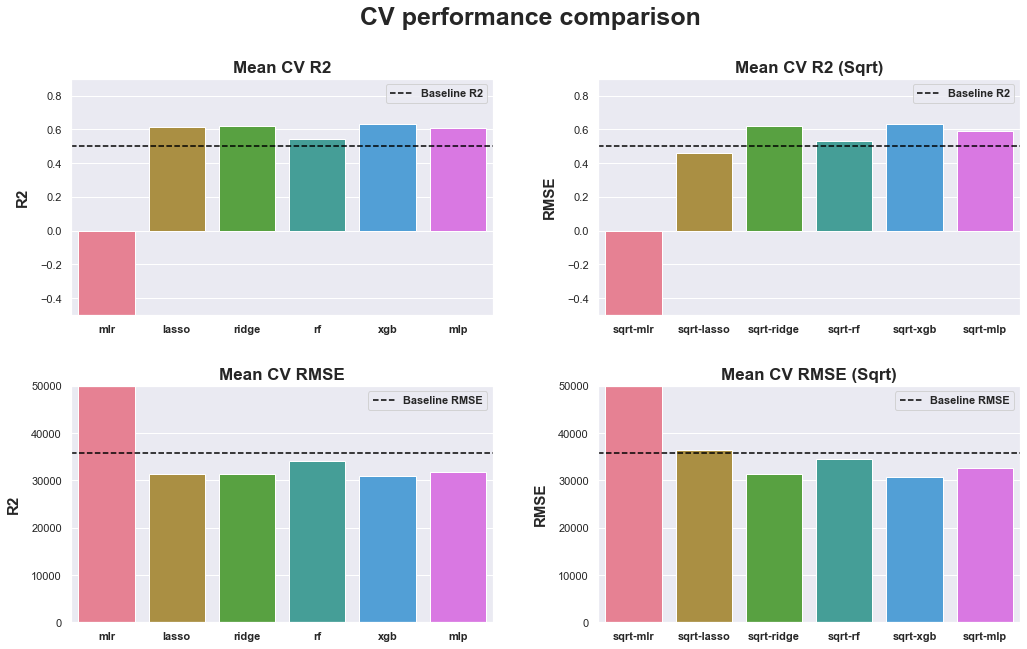

In [233]:
# Función para cargar los resultados de validación cruzada y calcular la media de las métricas
def load_cv_results(file_path, model_name):
    try:
        cv_results = pd.read_csv(file_path)
        mean_test_r2 = np.mean(cv_results['mean_test_r2']) 
        mean_test_rmse = np.mean(cv_results['mean_test_rmse'])  
        return {"model": model_name, "mean_test_r2": mean_test_r2, "mean_test_rmse": mean_test_rmse}
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


# Lista de modelos
models = ['mlr', 'lasso', 'ridge', 'rf', 'xgb', 'mlp']
# Lista de transformaciones
transformations = ['', 'sqrt-']

results = []

# Bucle para cargar y almacenar los resultados de cada modelo y transformación
for trans in transformations:
    for model in models:
        model_name = f"{trans}{model}"
        file_path = f"../../output/{model_name}-cv-results.csv"
        
        results.append(load_cv_results(file_path, model_name))
        

# Creación del DataFrame
results_df = pd.DataFrame(results)

sns.set_theme(style='darkgrid', palette='husl')

# Creación de la gráfica con subplots
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
fig.suptitle('CV performance comparison', fontsize=25, weight='bold')

# Modelos normales (sin sqrt)
non_sqrt_df = results_df[~results_df['model'].str.startswith('sqrt')]
sns.barplot(data=non_sqrt_df, x='model', y='mean_test_r2', ax=axes[0, 0])
axes[0, 0].set_title('Mean CV R2', weight='bold', fontsize=17)
axes[0, 0].set_ylim([-0.5, 0.9])
axes[0, 0].set_ylabel('R2', weight='bold', labelpad=10, fontsize=15)   

sns.barplot(data=non_sqrt_df, x='model', y='mean_test_rmse', ax=axes[1, 0])
axes[1, 0].set_title('Mean CV RMSE', weight='bold', fontsize=17)
axes[1, 0].set_ylim([0, 50000])
axes[1, 0].set_ylabel('R2', weight='bold', labelpad=10, fontsize=15)   

# Modelos con transformación sqrt
sqrt_df = results_df[results_df['model'].str.startswith('sqrt')]
sns.barplot(data=sqrt_df, x='model', y='mean_test_r2', ax=axes[0, 1])
axes[0, 1].set_title('Mean CV R2 (Sqrt)', weight='bold',fontsize=17)
axes[0, 1].set_ylim([-0.5, 0.9])
axes[0, 1].set_ylabel('RMSE', weight='bold', labelpad=10, fontsize=15)   

sns.barplot(data=sqrt_df, x='model', y='mean_test_rmse', ax=axes[1, 1])
axes[1, 1].set_title('Mean CV RMSE (Sqrt)', weight='bold',fontsize=17)
axes[1, 1].set_ylim([0, 50000])
axes[1, 1].set_ylabel('RMSE', weight='bold', labelpad=10, fontsize=15)  

# Agregando líneas verticales para representar las métricas del modelo base

axes[0, 0].axhline(mean_r2_baseline, color='black', linestyle='--', label='Baseline R2')
axes[0, 1].axhline(mean_r2_baseline, color='black', linestyle='--', label='Baseline R2')

axes[1, 0].axhline(mean_rmse_baseline, color='black', linestyle='--', label='Baseline RMSE')
axes[1, 1].axhline(mean_rmse_baseline, color='black', linestyle='--', label='Baseline RMSE')

# Rotar etiquetas para mejor visualización y retirar las etiquetas del eje x
for ax in axes.flatten():
    ax.set_xlabel('')  # Retira las etiquetas del eje x
    
    # Hacer las etiquetas del eje x en negrita
    for label in ax.get_xticklabels():
        label.set_weight('bold')
    
    # Configurar la leyenda en negrita
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_weight('bold')

fig.subplots_adjust(hspace=0.3, wspace=0.25)  # Ajusta el espacio entre subplots
plt.show()


In [234]:
pd.set_option('display.float_format', '{:.3f}'.format)

baseline_data = {"model": "baseline", "mean_test_r2": mean_r2_baseline, "mean_test_rmse": mean_rmse_baseline}
results_df = results_df.append(baseline_data, ignore_index=True)
results_df.set_index('model').sort_values(by='mean_test_r2', ascending=False)

C:\Users\fenan\AppData\Local\Temp\ipykernel_27968\4178027601.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(baseline_data, ignore_index=True)


,mean_test_r2,mean_test_rmse
model,,
sqrt-xgb,0.634,30721.288
xgb,0.628,30931.422
sqrt-ridge,0.621,31259.167
ridge,0.617,31437.558
lasso,0.616,31455.793
mlp,0.609,31760.477
sqrt-mlp,0.587,32645.553
rf,0.544,34098.728
sqrt-rf,0.530,34591.560
